# Gaussian Linear Dynamical System 

In this notebook, we will look at how we can fit a "Gaussian Linear Dynamical System," using the StateSpaceDynamics package. This model is a powerful tool for analyzing time series data and understanding underlying latent processes. For a reference of the details of this model please refer to Chapter 13.3 of Pattern Recognition and Machine Learning by Christopher Bishop.

## Setup

In [1]:
# import the relevant packages
using StateSpaceDynamics
using LinearAlgebra
using Random
using Plots
using LaTeXStrings

## Simulate a Gaussian LDS model

In [2]:
# create a state-space model for the tutorial
obs_dim = 10
latent_dim = 2

# set up the state parameters
A = 0.95 * [cos(0.25) -sin(0.25); sin(0.25) cos(0.25)] 
Q = Matrix(0.1 * I(2))

x0 = [0.0; 0.0]
P0 = Matrix(0.1 * I(2))

# set up the observation parameters
C = randn(obs_dim, latent_dim)
R = Matrix(0.5 * I(10))


# create the state-space model
true_ssm = GaussianLDS(;A=A, 
                        Q=Q, 
                        C=C, 
                        R=R, 
                        x0=x0, 
                        P0=P0, 
                        obs_dim=obs_dim, 
                        latent_dim=latent_dim, 
                        fit_bool=fill(true, 6))

# simulate data from the model
tSteps = 500
latents, observations = StateSpaceDynamics.sample(true_ssm, tSteps, 1) # one trial for tutorial purposes

([-0.2747514921538324 -0.2836300873424327 … -0.7458449730583252 -0.4243377891968177; 0.11019579941805606 0.023553609697458185 … -0.2881792712751505 -0.6586656750521916;;;], [1.0450360624307182 0.20465333199793515 … -1.063802019213783 -0.0470165248888374; -0.3370783308011916 -0.013658984627836157 … 2.2173599754272924 -0.16451251543582582; … ; 0.5706797236263332 -0.9132753219798551 … 0.4943388170544609 0.7976636301701501; -1.7953665301768404 -0.33583940846879495 … 0.31135249203826865 -1.3122387605901034;;;])

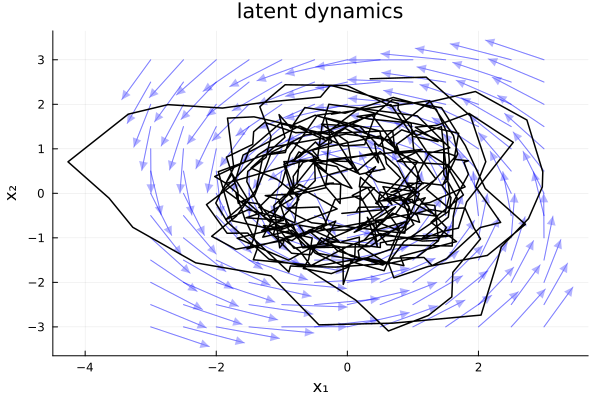

In [3]:
# Create a grid for the vector field
x = y = -3:0.5:3
X = repeat(x', length(y), 1)
Y = repeat(y, 1, length(x))

# Assuming x and y are your grid points
U = zeros(size(X))
V = zeros(size(Y))
for i in 1:size(X, 1)
    for j in 1:size(X, 2)
        v = A * [X[i,j], Y[i,j]]
        U[i,j] = v[1] - X[i,j]  # Change in x
        V[i,j] = v[2] - Y[i,j]  # Change in y
    end
end
# Normalize the vectors for better visualization
magnitude = @. sqrt(U^2 + V^2)
U_norm, V_norm = U ./ magnitude, V ./ magnitude

magnitude = @. sqrt(U^2 + V^2)
U_norm = U ./ magnitude
V_norm = V ./ magnitude

# Plot
p = quiver(X, Y, quiver=(U_norm, V_norm), color=:blue, alpha=0.3,
           linewidth=1, arrow=arrow(:closed, :head, 0.1, 0.1))
plot!(latents[1, :, 1], latents[2, :, 1], xlabel="x₁", ylabel="x₂", color=:black, linewidth=1.5, title="latent dynamics", legend=false)


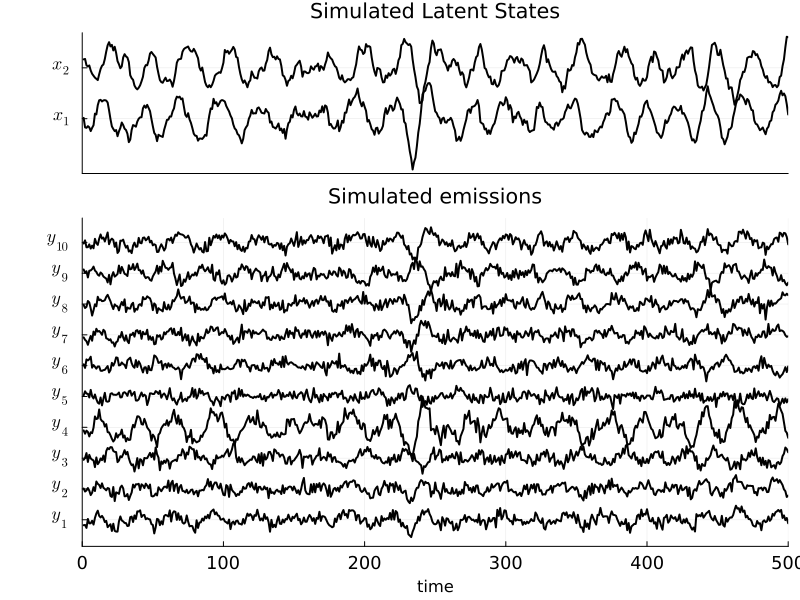

In [4]:
# Define parameters
state_dim = 2
obs_dim = 10
time_bins = 500

# Generate sample data
states = latents[:, :, 1]
emissions = observations[:, :, 1]

# Create the main plot
plot(size=(800, 600), layout=@layout[a{0.3h}; b])

# Plot the continuous latent states
lim_states = maximum(abs.(states))
for d in 1:state_dim
    plot!(1:time_bins, states[d, :] .+ lim_states * (d-1), color=:black, linewidth=2, label="", subplot=1)
end
plot!(subplot=1, yticks=(lim_states .* (0:state_dim-1), [L"x_%$d" for d in 1:state_dim]),
      xticks=[], xlims=(0, time_bins), title="Simulated Latent States",
      yformatter=y->"", tickfontsize=12)

# Plot the emissions
lim_emissions = maximum(abs.(emissions))
for n in 1:obs_dim
    plot!(1:time_bins, emissions[n, :] .- lim_emissions * (n-1), color=:black, linewidth=2, label="", subplot=2)
end
plot!(subplot=2, yticks=(-lim_emissions .* (obs_dim-1:-1:0), [L"y_{%$n}" for n in 1:obs_dim]),
      xlabel="time", xlims=(0, time_bins), title="Simulated emissions",
      yformatter=y->"", tickfontsize=12)

# Adjust layout
plot!(link=:x, size=(800, 600), left_margin=10Plots.mm)

# Display the plot
display(current())

# Uncomment to save the figure
# savefig("simulated_latent_states_and_emissions.png")

## Create and fit a Gaussian LDS model to Data

In [3]:
# create a Gaussian LDS with unknow parameters (except the dimensions)
naive_ssm = GaussianLDS(;obs_dim=obs_dim, latent_dim=latent_dim, fit_bool=fill(true, 6))

# smooth the data to look at the predicted latent states
x_smooth, p_smooth, _ = StateSpaceDynamics.smooth(naive_ssm, observations)

# create a plot to compare the true and predicted latent states
plot()

# plot the true latent states
for d in 1:state_dim
    plot!(1:time_bins, states[d, :] .+ lim_states * (d-1), color=:black, linewidth=2, label="", subplot=1)
end

# plot the predicted latent states
for d in 1:state_dim
    plot!(1:time_bins, x_smooth[d, :, 1] .+ lim_states * (d-1), color=:firebrick, linewidth=2, label="", subplot=1)
end

plot!(subplot=1, yticks=(lim_states .* (0:state_dim-1), [L"x_%$d" for d in 1:state_dim]),
      xticks=[], xlims=(0, time_bins), yformatter=y->"", tickfontsize=12, title="True vs. Predicted Latent States")


UndefVarError: UndefVarError: `state_dim` not defined

In [4]:
# now fit the LDS using the EM algorithm
elbo, _ = fit!(naive_ssm, observations; max_iter=100, tol=1e-6)

# smooth the data to look at the predicted latent states
x_smooth, p_smooth, _ = StateSpaceDynamics.smooth(naive_ssm, observations)

# create a plot to compare the true and predicted latent states
plot()

# plot the true latent states
for d in 1:state_dim
    plot!(1:time_bins, states[d, :] .+ lim_states * (d-1), color=:black, linewidth=2, label="", subplot=1)
end

# plot the predicted latent states
for d in 1:state_dim
    plot!(1:time_bins, x_smooth[d, :, 1] .+ lim_states * (d-1), color=:firebrick, linewidth=2, label="", subplot=1)
end

plot!(subplot=1, yticks=(lim_states .* (0:state_dim-1), [L"x_%$d" for d in 1:state_dim]),
      xticks=[], xlims=(0, time_bins), yformatter=y->"", tickfontsize=12, title="True vs. Predicted Latent States")

CompositeException: TaskFailedException

    nested task error: MethodError: no method matching Q_function(::Matrix{Float64}, ::Matrix{Float64}, ::Matrix{Float64}, ::Matrix{Float64}, ::Matrix{Float64}, ::Vector{Float64}, ::SubArray{Float64, 2, Array{Float64, 3}, Tuple{Base.Slice{Base.OneTo{Int64}}, Base.Slice{Base.OneTo{Int64}}, Int64}, true}, ::SubArray{Float64, 3, Array{Float64, 4}, Tuple{Base.Slice{Base.OneTo{Int64}}, Base.Slice{Base.OneTo{Int64}}, Base.Slice{Base.OneTo{Int64}}, Int64}, true}, ::SubArray{Float64, 3, Array{Float64, 4}, Tuple{Base.Slice{Base.OneTo{Int64}}, Base.Slice{Base.OneTo{Int64}}, Base.Slice{Base.OneTo{Int64}}, Int64}, true}, ::SubArray{Float64, 2, Array{Float64, 3}, Tuple{Base.Slice{Base.OneTo{Int64}}, Base.Slice{Base.OneTo{Int64}}, Int64}, true})
    
    Closest candidates are:
      Q_function(::Matrix{<:Real}, ::AbstractMatrix{<:Real}, ::Matrix{<:Real}, ::AbstractMatrix{<:Real}, ::AbstractMatrix{<:Real}, ::Vector{<:Real}, !Matched::Matrix{<:Real}, !Matched::Array{<:Real, 3}, !Matched::Array{<:Real, 3}, !Matched::Matrix{<:Real})
       @ StateSpaceDynamics \Users\ryansenne\Documents\GitHub\ssm_julia\src\LinearDynamicalSystems.jl:755
      Q_function(::Matrix{T}, ::Matrix{T}, ::Matrix{T}, !Matched::Vector{T}, !Matched::Vector{T}, !Matched::Matrix{T}, !Matched::Array{T, 3}, !Matched::Array{T, 4}, !Matched::Array{T, 4}, !Matched::Array{T, 4}, !Matched::Array{T, 3}) where T<:Real
       @ StateSpaceDynamics \Users\ryansenne\Documents\GitHub\ssm_julia\src\LinearDynamicalSystems.jl:1690
    
    Stacktrace:
     [1] macro expansion
       @ .\Users\ryansenne\Documents\GitHub\ssm_julia\src\LinearDynamicalSystems.jl:884 [inlined]
     [2] (::StateSpaceDynamics.var"#111#threadsfor_fun#29"{StateSpaceDynamics.var"#111#threadsfor_fun#28#30"{StateSpaceDynamics.LinearDynamicalSystem{StateSpaceDynamics.GaussianStateModel{Float64}, StateSpaceDynamics.GaussianObservationModel{Float64}}, Array{Float64, 3}, Array{Float64, 4}, Array{Float64, 4}, Array{Float64, 3}, Vector{Float64}, UnitRange{Int64}}})(tid::Int64; onethread::Bool)
       @ StateSpaceDynamics .\threadingconstructs.jl:215
     [3] #111#threadsfor_fun
       @ .\threadingconstructs.jl:182 [inlined]
     [4] (::Base.Threads.var"#1#2"{StateSpaceDynamics.var"#111#threadsfor_fun#29"{StateSpaceDynamics.var"#111#threadsfor_fun#28#30"{StateSpaceDynamics.LinearDynamicalSystem{StateSpaceDynamics.GaussianStateModel{Float64}, StateSpaceDynamics.GaussianObservationModel{Float64}}, Array{Float64, 3}, Array{Float64, 4}, Array{Float64, 4}, Array{Float64, 3}, Vector{Float64}, UnitRange{Int64}}}, Int64})()
       @ Base.Threads .\threadingconstructs.jl:154

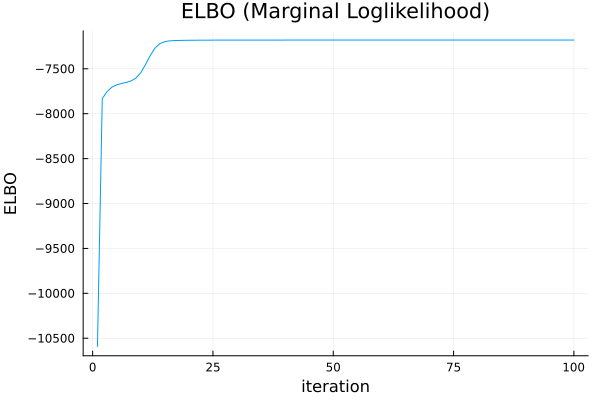

In [7]:
plot(elbo, xlabel="iteration", ylabel="ELBO", title="ELBO (Marginal Loglikelihood)", legend=false)

In [ ]:
"""
    sampleposterior(statemodel::GaussianStateModel, observationmodel::AbstractObservationModel, xsmooth::Array{T, 3}, psmooth::Array{T, 4}, n::Int=1) where T <: Real

Sample from the posterior distribution of the latent states.

# Arguments
- `statemodel::GaussianStateModel`: A GaussianStateModel object.
- `observationmodel::AbstractObservationModel`: An AbstractObservationModel object.
- `xsmooth::Array{T, 3}`: The smoothed latent states.
- `psmooth::Array{T, 4}`: The smoothed latent state covariances.
- `n::Int`: The number of samples to draw. Default is 1.
"""
function sampleposterior(
        statemodel::GaussianStateModel,
        observationmodel::AbstractObservationModel,
        xsmooth::Array{T, 3},
        psmooth::Array{T, 4},
        n::Int=1
    ) where T <: Real

    # get the dimensions of the state space
    state_dim, tsteps, trials = size(xsmooth)

    # initialize the array to store the samples
    samples = zeros(T, state_dim, time_bins, trials, n)

    # sample from the posterior distribution
    for i in 1:n
        for tr in 1:trials
            for t in 1:tsteps
                samples[:, t, tr, i] = rand(MvNormal(xsmooth[:, t, tr], psmooth[:, :, t, tr]))
            end
        end
    end

    return samples
end